In [2]:
# -------------------------------
# 0. 라이브러리 및 환경 설정
# -------------------------------
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from scipy.stats import zscore, pointbiserialr
from sklearn.preprocessing import PowerTransformer
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings("ignore")

# 그래프 한글폰트(선택) ─ macOS 예시
plt.rcParams['font.family'] = 'AppleGothic'
# plt.rcParams['font.family'] = 'Apple SD Gothic Neo' # 띄어쓰기 포함
plt.rcParams['axes.unicode_minus'] = False
sns.set_style('whitegrid')

In [8]:
kospi = pd.read_csv("../data/raw/코스피_상장폐지.csv")
kosdaq = pd.read_csv("../data/raw/코스닥_상장폐지.csv")

In [9]:
kospi['폐지사유'].unique().tolist()

['신청에 의한 상장폐지',
 '감사의견 의견거절 2년 계속',
 '지주회사(최대주주등)의 완전자회사화 등',
 '해산 사유 발생',
 '감사의견 부적정',
 '존속기간 만료',
 '감사의견 의견거절',
 '기업의 계속성, 경영의 투명성 및 기타 공익과 투자자 보호 등을 종합적으로 고려하여 상장폐지 기준에 해당한다고 결정',
 '자본전액잠식',
 '시가총액 미달',
 '매출액 미달(50억원 미만) 2년 계속',
 '공시서류 미제출(사업보고서) 후 10일이내 미제출',
 '보통주 주식분포요건 미충족 2년 계속',
 '지주회사의 완전자회사화(지주회사 신규상장)',
 'SPAC 상장예비심사청구서 미제출 등',
 '보통주 주가수준미달',
 '자본잠식(자본금의 50/100이상 잠식) 2년 계속',
 '최종부도발생']

In [16]:
kosdaq['폐지사유'].unique().tolist()

['상장예비심사 청구서 미제출로 관리종목 지정 후 1개월 이내 동 사유 미해소',
 '피흡수합병(스팩소멸합병)',
 '타법인의 완전자회사로 편입',
 '기업의 계속성 및 경영의 투명성 등을 종합적으로 고려하여 상장폐지기준에 해당한다고 결정',
 '감사의견 거절(감사범위 제한)',
 "상장폐지 신청('23.06.28)",
 '유가증권시장 상장',
 '감사의견 거절(감사범위 제한 및 계속기업가정 불확실성)',
 '감사의견 거절(감사범위 제한 및 계속기업 존속능력 불확실성)',
 '피흡수합병',
 '기업의 계속성 및 경영의 투명성 등을 종합적을 고려하여 상장폐지기준에 해당한다고 결정',
 "상장폐지 신청('22.08.31)",
 '상장예비심사 청구서 미제출로 관리종목 지정 후 1개월 이내 동사유 미해소',
 "상장폐지 신청('22.03.30)",
 '감사의견 거절',
 '감사의견 거절(감사범위 제한 및 계속기업 존속능력에 대한 불확실성)',
 "상장폐지 신청('22.04.14)",
 '발행한 어음 또는 수표가 주거래은행에 의하여 최종부도로 결정되거나 거래은행에 의한 거래정지',
 '해산사유 발생(파산선고)',
 '상장예비심사청구서 미제출',
 '감사의견 한정(감사범위 제한)',
 '법정제출기한까지 사업보고서를 제출하지 아니한 후, 법정제출기한의 다음날부터 10일이내에 사업보고서를 제출하지 아니함',
 '기업의 계속성 및 경영의 투명성 등을 종합적으로 고려하여 상장폐지기준에 해당',
 '최근 2년간 3회 이상 공시규정 제19조제1항의 규정에 의한 사업보고서, 반기보고서 또는 분기보고서 법정제출기한 내 미제출',
 '감사의견거절(감사범위 제한)',
 '감사의견거절(감사범위제한)',
 '감사의견거절(감사범위제한 및 계속기업 존속 불확실)',
 '제28조제1항제9호에 따라 관리종목 지정 후 공시규정 제19조제1항에 따른 사업보고서 법정제출기한 내 미제출, 최근 2년간 3회 이상 공시규정 제19조제1항의 규정에 의한 사업보고서, 반기보고서 또는 분기보고서 법정제출기한 내 미

In [61]:
c_ratio = pd.read_csv("../data/raw/연결 재무비율(IFRS).csv")
n_ratio = pd.read_csv("../data/raw/재무비율(IFRS).csv")
c_bs = pd.read_csv("../data/raw/연결 재무제표(IFRS).csv")
n_bs = pd.read_csv("../data/raw/재무제표(IFRS).csv")
delisting = pd.concat([kospi, kosdaq])
df = pd.DataFrame()

In [30]:
c_bs.columns.tolist()

['회사명',
 '거래소코드',
 '회계년도',
 '[A100000000]자산(*)(IFRS연결)(천원)',
 '[A600000000]자본(*)(IFRS연결)(천원)',
 '[A600010000]* 수권주식수(IFRS연결)(주)',
 '[A600010100]* 주당 액면가액(IFRS연결)(원)',
 '[A600010200]* 발행한 주식총수(*)(IFRS연결)(천원)',
 '[A600010300]   보통주(IFRS연결)(주)',
 '[A600010400]   우선주(IFRS연결)(주)',
 '[A610000000]   지배기업주주지분(*)(IFRS연결)(천원)',
 '[A611000000]      자본금(*)(IFRS연결)(천원)',
 '[A611010000]         보통주자본금(IFRS연결)(천원)',
 '[A611010100]         우선주자본금(IFRS연결)(천원)',
 '[A611050000]      신종자본증권(IFRS연결)(천원)',
 '[A612000000]      자본잉여금(*)(IFRS연결)(천원)',
 '[A612010000]         주식발행초과금(IFRS연결)(천원)',
 '[A612010100]         배당건설이자(IFRS연결)(천원)',
 '[A612010200]         주식매입선택권(IFRS연결)(천원)',
 '[A612010300]         감자차익(IFRS연결)(천원)',
 '[A612010400]         보험차익(IFRS연결)(천원)',
 '[A612010500]         합병차익(IFRS연결)(천원)',
 '[A612010600]         자산수증이익(IFRS연결)(천원)',
 '[A612010700]         채무면제이익(IFRS연결)(천원)',
 '[A612010800]         자기주식처분이익(IFRS연결)(천원)',
 '[A612010900]         전환권대가(IFRS연결)(천원)',
 '[A612011000]         신주인수권대가

In [59]:
n_bs.columns.tolist()

['회사명',
 '거래소코드',
 '회계년도',
 '[A100000000]자산(*)(IFRS)(천원)',
 '[A600000000]자본(*)(IFRS)(천원)',
 '[A600010000]* 수권주식수(IFRS)(주)',
 '[A600010100]* 주당 액면가액(IFRS)(원)',
 '[A600010300]   보통주(IFRS)(주)',
 '[A600010400]   우선주(IFRS)(주)',
 '[A611010000]      보통주자본금(IFRS)(천원)',
 '[A611010100]      우선주자본금(IFRS)(천원)',
 '[A611050000]   신종자본증권(IFRS)(천원)',
 '[A612010000]      주식발행초과금(IFRS)(천원)',
 '[A612010100]      배당건설이자(IFRS)(천원)',
 '[A612010200]      주식매입선택권(IFRS)(천원)',
 '[A612010300]      감자차익(IFRS)(천원)',
 '[A612010400]      보험차익(IFRS)(천원)',
 '[A612010500]      합병차익(IFRS)(천원)',
 '[A612010600]      자산수증이익(IFRS)(천원)',
 '[A612010700]      채무면제이익(IFRS)(천원)',
 '[A612010800]      자기주식처분이익(IFRS)(천원)',
 '[A612010900]      전환권대가(IFRS)(천원)',
 '[A612011000]      신주인수권대가(IFRS)(천원)',
 '[A612011100]      교환권대가(IFRS)(천원)',
 '[A612011200]      전환권재매입이익(IFRS)(천원)',
 '[A612011300]      기타자본잉여금(IFRS)(천원)',
 '[A612011400]      재평가적립금(2001년 이전)(IFRS)(천원)',
 '[A613000000]   기타자본(*)(IFRS)(천원)',
 '[A614000000]   기타포괄손익누계액(*)(I

In [95]:
bs = pd.read_csv("../data/processed/BS.csv")
ratio = pd.read_csv("../data/processed/ratio.csv")

print(bs.shape)
print(ratio.shape)

df = pd.concat([bs, ratio], axis=1)
df.to_csv("../data/processed/bs_ratio.csv", index=False)

(27921, 508)
(27921, 67)


In [104]:
df.columns

Index(['[A100000000]자산(*)(IFRS연결)(천원)', '[A600000000]자본(*)(IFRS연결)(천원)',
       '[A800000000]부채(*)(IFRS연결)(천원)',
       '[B420000000]* (정상)영업손익(보고서기재)(IFRS연결)(천원)',
       '[B840000000]당기순이익(손실)(IFRS연결)(천원)', '부채비율(IFRS연결)'],
      dtype='object')

In [107]:
df.columns.tolist()

['회사명',
 '거래소코드',
 '회계년도',
 '[A100000000]자산(*)(IFRS연결)(천원)',
 '[A600000000]자본(*)(IFRS연결)(천원)',
 '[A600010000]* 수권주식수(IFRS연결)(주)',
 '[A600010100]* 주당 액면가액(IFRS연결)(원)',
 '[A600010200]* 발행한 주식총수(*)(IFRS연결)(천원)',
 '[A600010300]   보통주(IFRS연결)(주)',
 '[A600010400]   우선주(IFRS연결)(주)',
 '[A610000000]   지배기업주주지분(*)(IFRS연결)(천원)',
 '[A611000000]      자본금(*)(IFRS연결)(천원)',
 '[A611010000]         보통주자본금(IFRS연결)(천원)',
 '[A611010100]         우선주자본금(IFRS연결)(천원)',
 '[A611050000]      신종자본증권(IFRS연결)(천원)',
 '[A612000000]      자본잉여금(*)(IFRS연결)(천원)',
 '[A612010000]         주식발행초과금(IFRS연결)(천원)',
 '[A612010100]         배당건설이자(IFRS연결)(천원)',
 '[A612010200]         주식매입선택권(IFRS연결)(천원)',
 '[A612010300]         감자차익(IFRS연결)(천원)',
 '[A612010400]         보험차익(IFRS연결)(천원)',
 '[A612010500]         합병차익(IFRS연결)(천원)',
 '[A612010600]         자산수증이익(IFRS연결)(천원)',
 '[A612010700]         채무면제이익(IFRS연결)(천원)',
 '[A612010800]         자기주식처분이익(IFRS연결)(천원)',
 '[A612010900]         전환권대가(IFRS연결)(천원)',
 '[A612011000]         신주인수권대가

In [3]:
# -------------------------------
# 1. 데이터 불러오기
# -------------------------------
### TODO: 실제 파일 경로를 지정하세요
df = pd.read_csv("../data/processed/bs_ratio.csv")

# -------------------------------
# 2. 주요 변수 지정
# -------------------------------
### TODO: 컬럼명을 실제 데이터에 맞춰 수정
id_col      = '거래소코드'
keep_cols = [
    '[A100000000]자산(*)(IFRS연결)(천원)',                                    # 총자산
    '[A800000000]부채(*)(IFRS연결)(천원)',                                    # 총부채
    '[A600000000]자본(*)(IFRS연결)(천원)',                                    # 자본
    '[B420000000]* (정상)영업손익(보고서기재)(3개월)(IFRS연결)(천원)',     # 영업이익 (분기)
    '[B840000000]당기순이익(손실)(3개월)(IFRS연결)(천원)',                   # 순이익 (분기)
    '[D100000000]영업활동으로 인한 현금흐름(간접법)(*)(IFRS연결)(천원)',    # 영업현금흐름
    '부채비율(IFRS연결)',                                                      # Debt Ratio
    '차입금의존도(IFRS연결)',                                                  # Borrowing Dependence
    '총자본회전률(IFRS연결)',                                                  # Asset Turnover
    'PBR(최저)(IFRS연결)'                                                      # PBR (Lowest)
]
df = df.drop(columns=[c for c in df.columns if c not in keep_cols])
df.columns = ['Asset', 'Debt', 'Equity', 'OperatingIncome', 'NetIncome', 'OperatingCashFlow', 'DebtRatio', 'BorrowingDependence', 'AssetTurnover', 'PBR']
cat_cols = []                  # 범주형 변수 있다면 추가
df.columns

Index(['Asset', 'Debt', 'Equity', 'OperatingIncome', 'NetIncome',
       'OperatingCashFlow', 'DebtRatio', 'BorrowingDependence',
       'AssetTurnover', 'PBR'],
      dtype='object')

In [122]:
# 2-1. 정보 요약
display(df.info())
display(df.head())

# # 2-2. 중복 확인 (동일 기업·연도 중복행 탐지)
# dup_mask = df.duplicated(subset=[id_col, 'year'])
# print(f"중복 행 수: {dup_mask.sum()}")
# if dup_mask.any():
#     df = df[~dup_mask]  # 필요 시 제거

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27921 entries, 0 to 27920
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Asset                25603 non-null  float64
 1   Debt                 25603 non-null  float64
 2   Equity               25603 non-null  float64
 3   OperatingIncome      23217 non-null  float64
 4   NetIncome            23217 non-null  float64
 5   OperatingCashFlow    25603 non-null  float64
 6   DebtRatio            25117 non-null  float64
 7   BorrowingDependence  25117 non-null  float64
 8   AssetTurnover        25117 non-null  float64
 9   PBR                  24987 non-null  float64
dtypes: float64(10)
memory usage: 2.1 MB


None

,Asset,Debt,Equity,OperatingIncome,NetIncome,OperatingCashFlow,DebtRatio,BorrowingDependence,AssetTurnover,PBR
0,57108035.0,31590685.0,25517350.0,-1154630.0,-3529031.0,-1572581.0,80.77,30.58,0.39,0.78
1,55912563.0,48997281.0,6915281.0,-244216.0,-245507.0,-3939013.0,14.11,2.53,0.36,1.73
2,58068326.0,49002644.0,9065682.0,181298.0,-108400.0,724893.0,18.50,2.66,0.40,1.96
3,56532821.0,46806888.0,9725933.0,-1649356.0,-2930942.0,2410205.0,20.78,0.01,0.47,2.27
4,110979867.0,101107635.0,9872232.0,695363.0,630984.0,3321352.0,9.76,0.00,0.39,1.80


OperatingIncome        0.168475
NetIncome              0.168475
PBR                    0.105082
DebtRatio              0.100426
BorrowingDependence    0.100426
AssetTurnover          0.100426
Asset                  0.083020
Debt                   0.083020
Equity                 0.083020
OperatingCashFlow      0.083020
dtype: float64

<Figure size 1000x400 with 0 Axes>

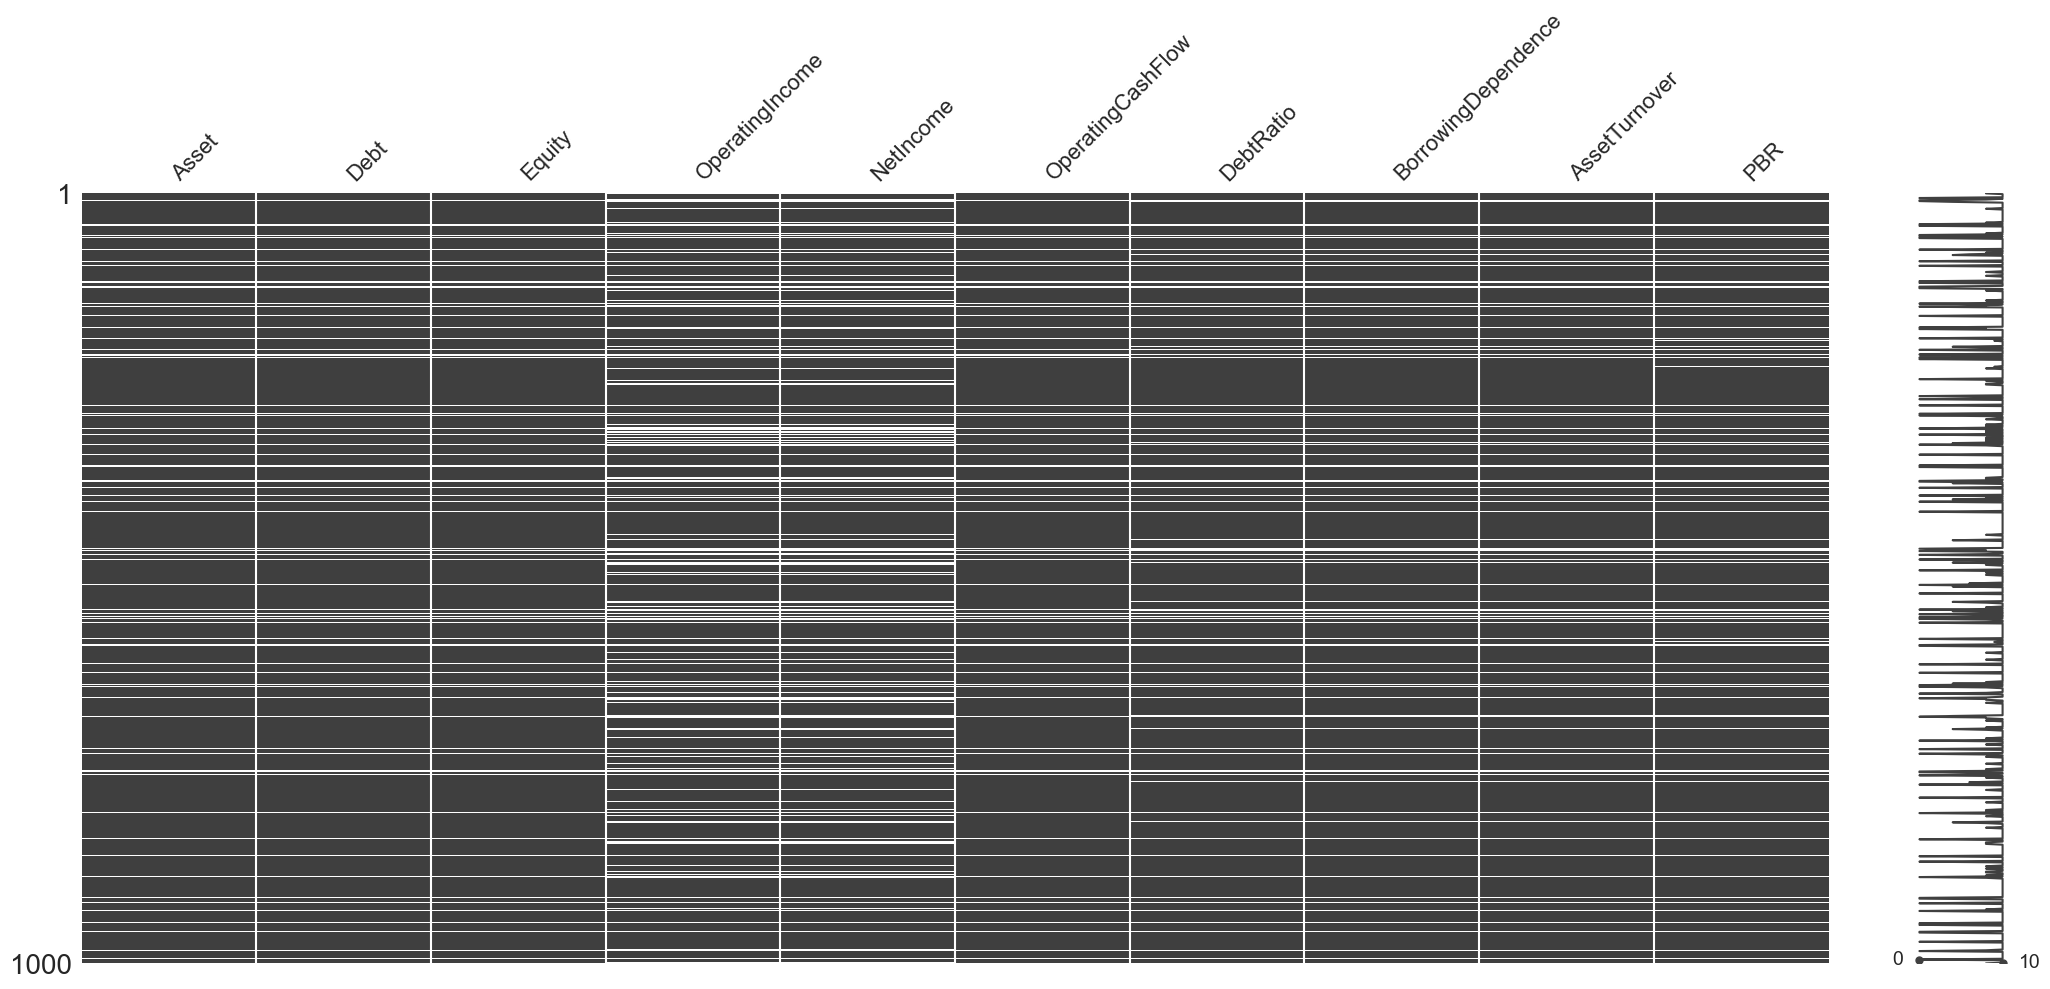

In [123]:
# 3-1. 변수별 결측 비율
null_ratio = df.isna().mean().sort_values(ascending=False)
display(null_ratio.head(10))

# 3-2. 히트맵 시각화
plt.figure(figsize=(10,4))
msno.matrix(df.sample(min(1000, len(df_bs))))
plt.show()

,count,mean,std,min,25%,50%,75%,max
Asset,25603.0,1.513635e+09,1.135896e+10,0.000000e+00,67380620.50,1.489059e+08,4.247088e+08,4.559060e+11
Debt,25603.0,7.048613e+08,6.327010e+09,-2.666885e+09,37408128.50,8.323151e+07,2.184717e+08,3.636779e+11
Equity,25603.0,8.087742e+08,6.192772e+09,0.000000e+00,21471975.50,5.706875e+07,1.832668e+08,2.024502e+11
OperatingIncome,23217.0,1.451568e+07,2.429590e+08,-1.082094e+10,-842386.00,1.093260e+06,5.037711e+06,1.514697e+10
NetIncome,23217.0,5.465434e+06,2.573669e+08,-7.783151e+09,-3143848.00,3.100950e+05,3.345686e+06,2.384145e+10
OperatingCashFlow,25603.0,9.466110e+07,1.275843e+09,-2.347750e+10,-1013418.50,5.531789e+06,2.330137e+07,6.703186e+10
DebtRatio,25117.0,1.373367e+02,8.258980e+02,0.000000e+00,32.78,7.198000e+01,1.385700e+02,8.451024e+04
BorrowingDependence,25117.0,2.251186e+01,2.067151e+01,0.000000e+00,6.11,1.991000e+01,3.463000e+01,7.494000e+02
AssetTurnover,25117.0,8.658522e-01,5.543095e-01,0.000000e+00,0.50,7.700000e-01,1.110000e+00,8.170000e+00
PBR,24987.0,1.474248e+00,1.744892e+01,-3.140000e+00,0.48,8.500000e-01,1.510000e+00,2.467540e+03


z>|3| 이상치 행 비율: 0.00%


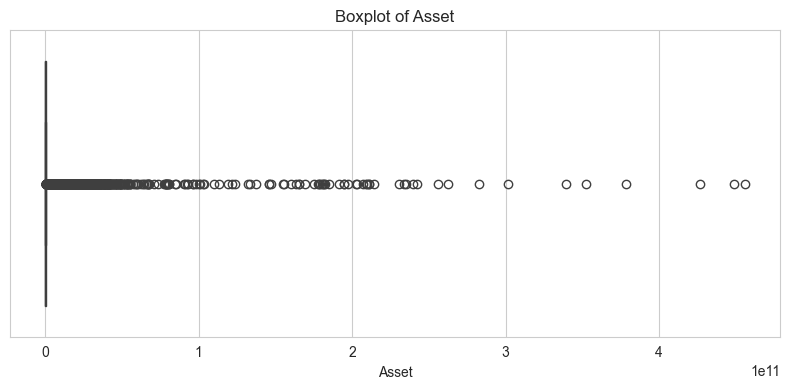

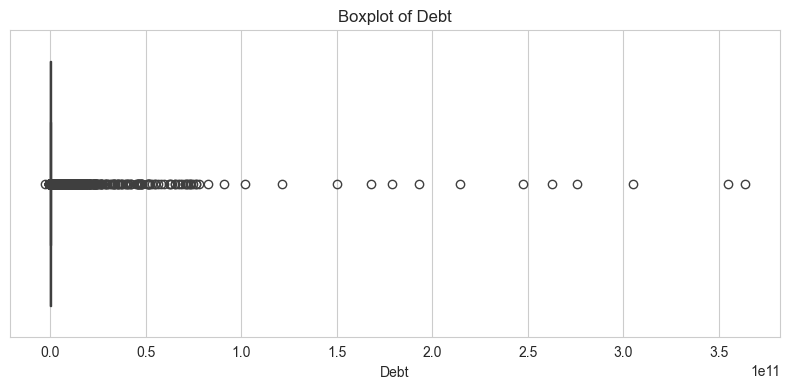

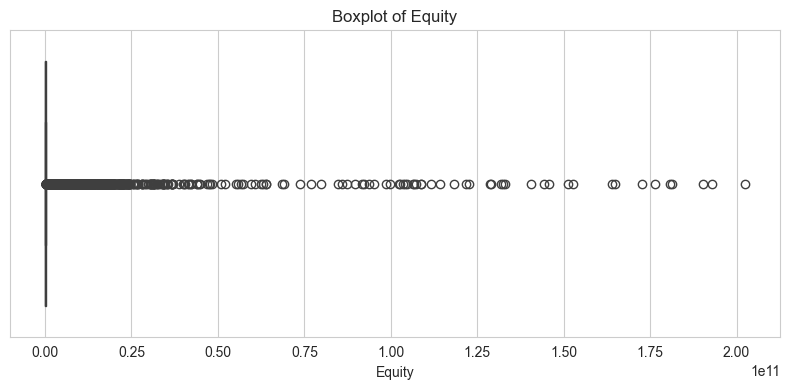

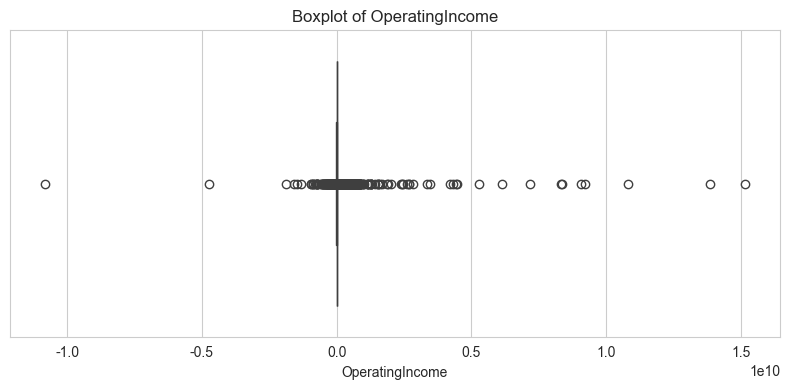

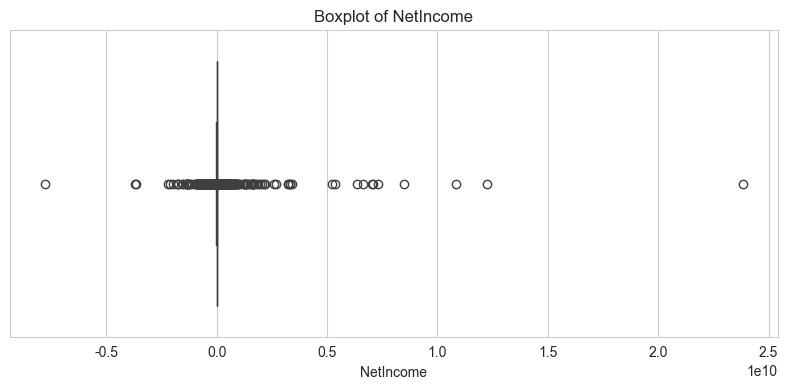

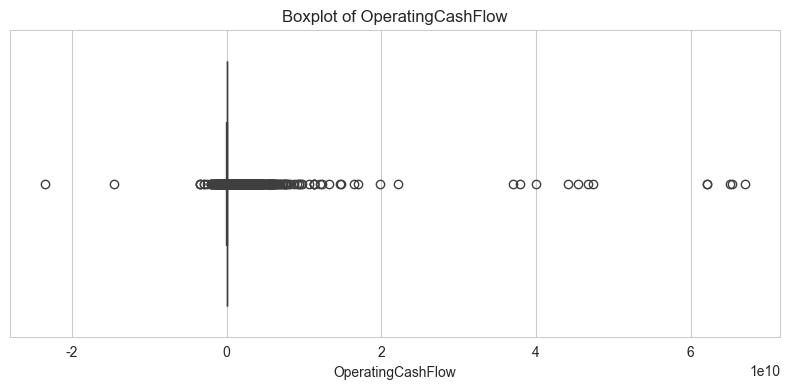

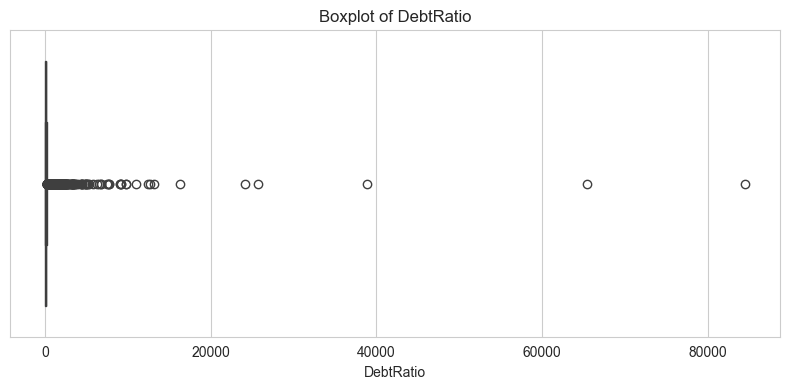

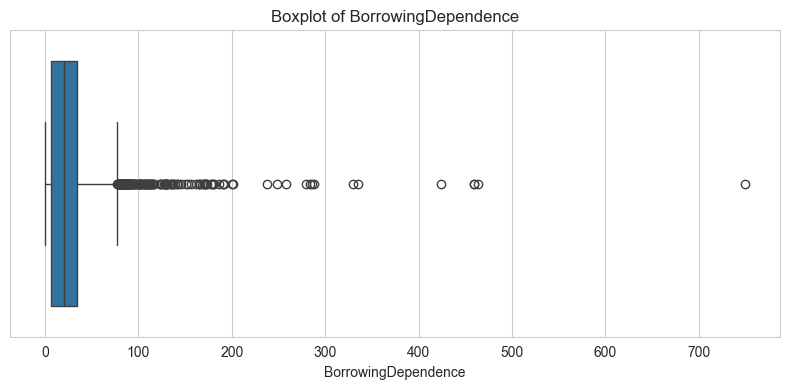

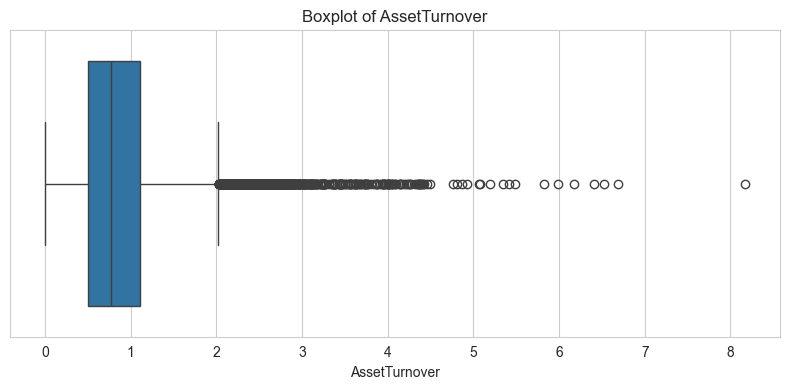

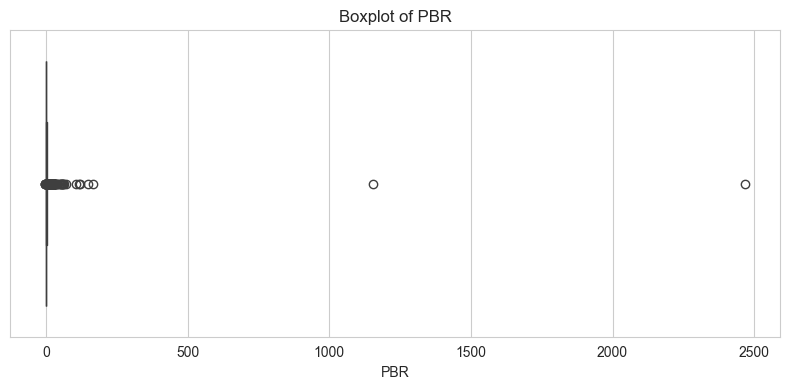

In [127]:
# 4-1. 기술통계
desc = df.describe().T
display(desc)

# 4-2. z-score 기반 이상치 마스크
z_scores = df.apply(zscore)
outlier_mask = (np.abs(z_scores) > 3).any(axis=1)
print(f"z>|3| 이상치 행 비율: {outlier_mask.mean():.2%}")

# 4-3. 상자그림(샘플 10개 변수)
numeric_cols = df.select_dtypes(include='number').columns

for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[col], orient='h')
    plt.title(f"Boxplot of {col}")
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()

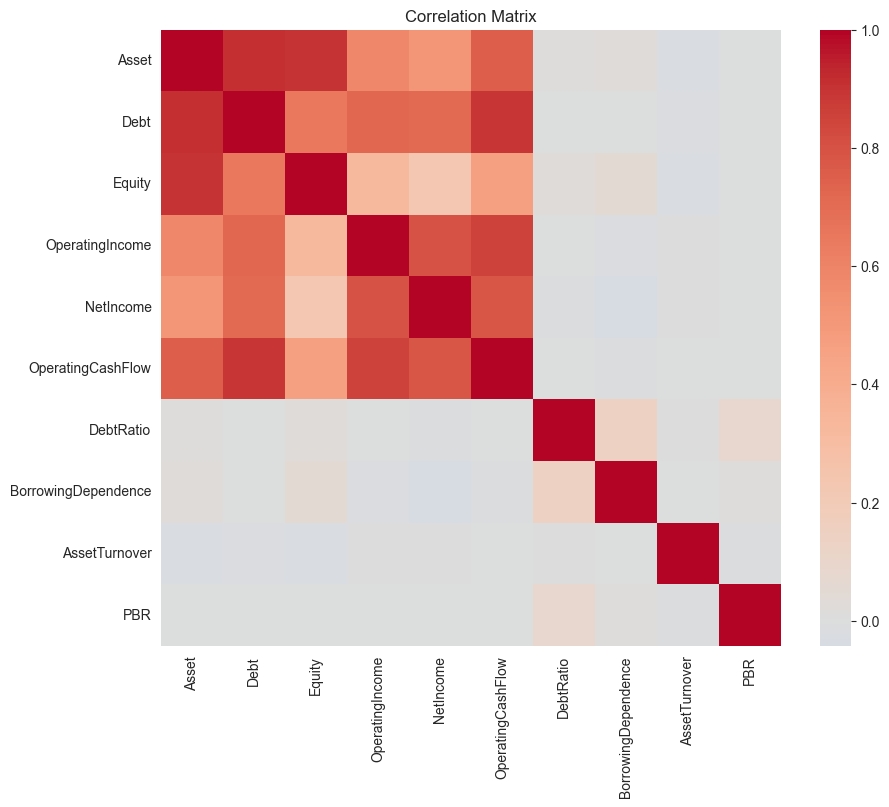

In [126]:
# 6-1. 피어슨 상관행렬
corr = df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap='coolwarm', center=0, annot=False)
plt.title("Correlation Matrix"); plt.show()

# # 6-2. VIF 계산
# X = df.drop(columns=[], errors='ignore')  # 필요 시 제외 변수 지정
# vif_vals = pd.Series(
#     [variance_inflation_factor(X.values, i) for i in range(X.shape[1])],
#     index=X.columns, name='VIF'
# )
# display(vif_vals.sort_values(ascending=False).head(10))

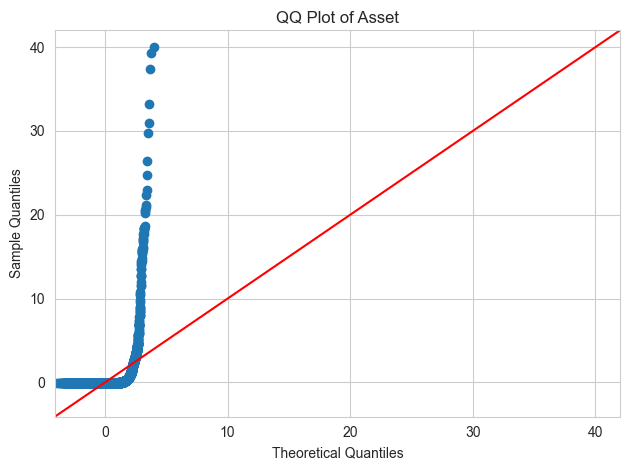

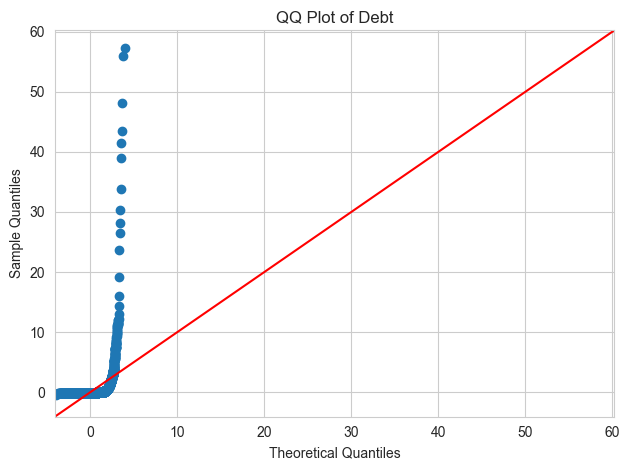

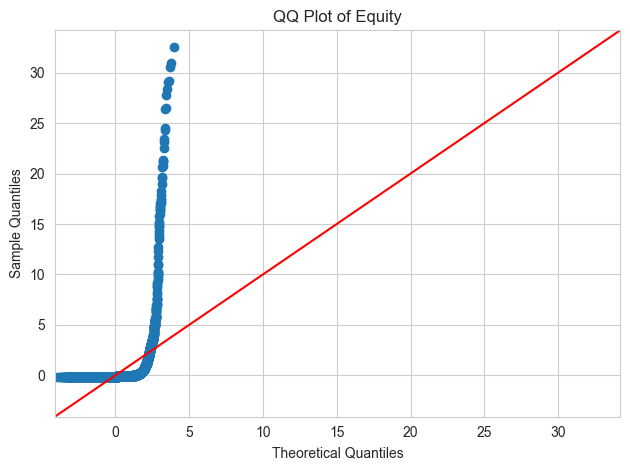

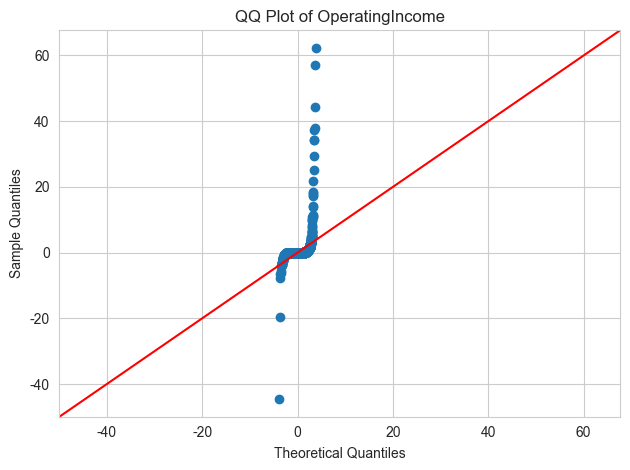

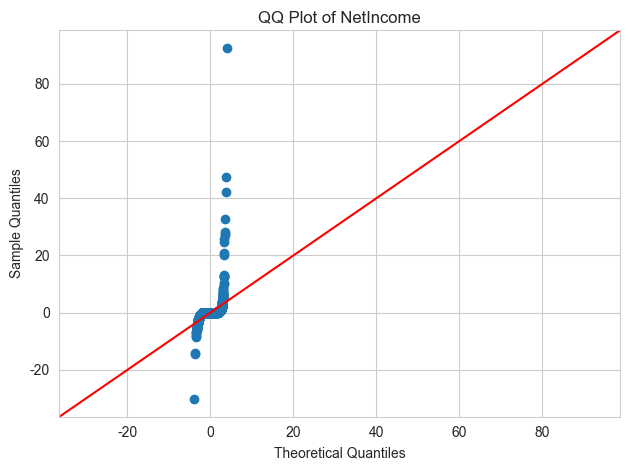

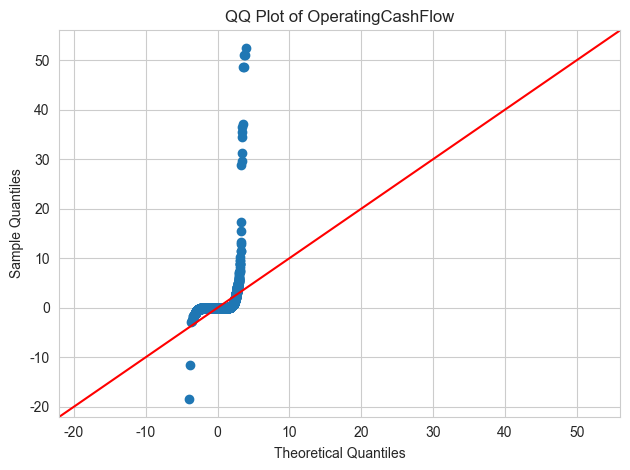

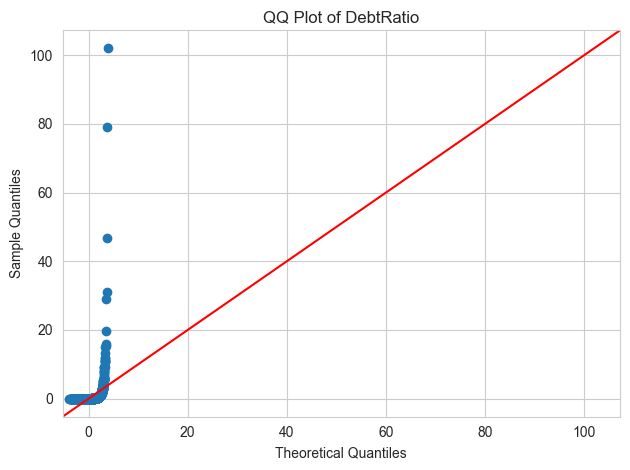

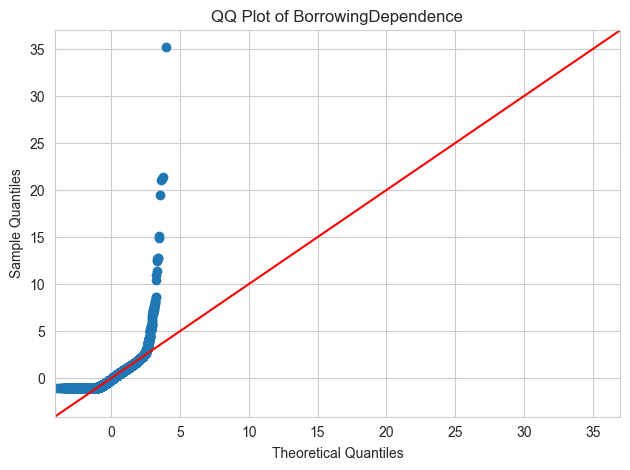

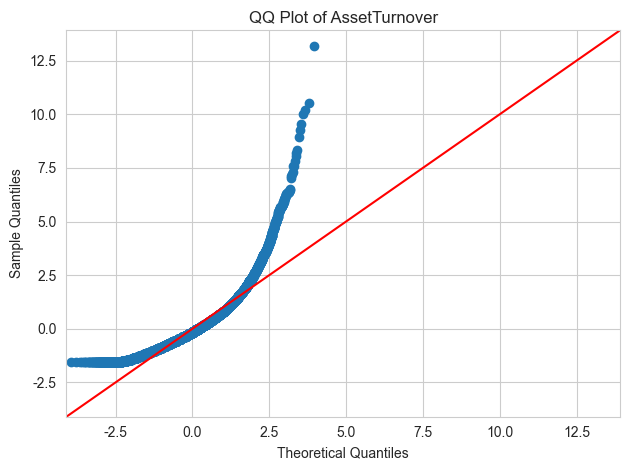

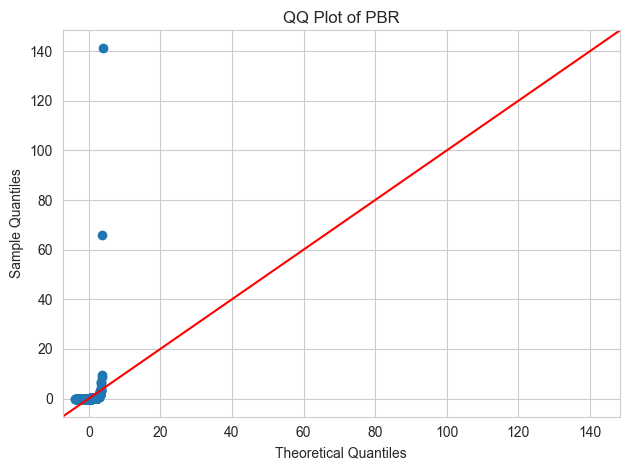

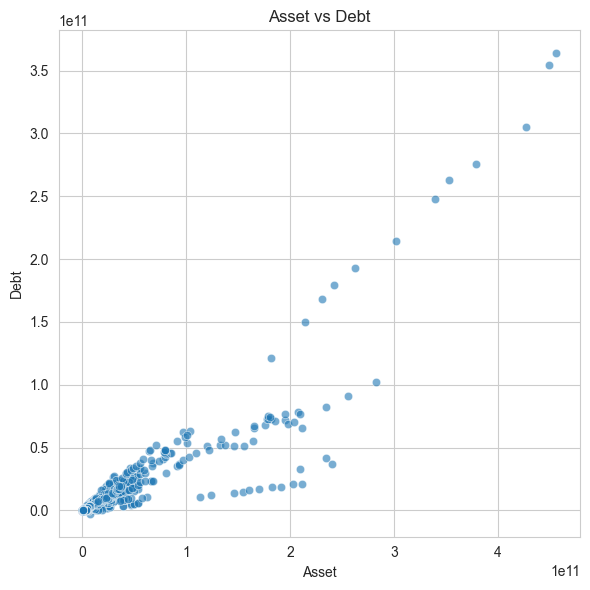

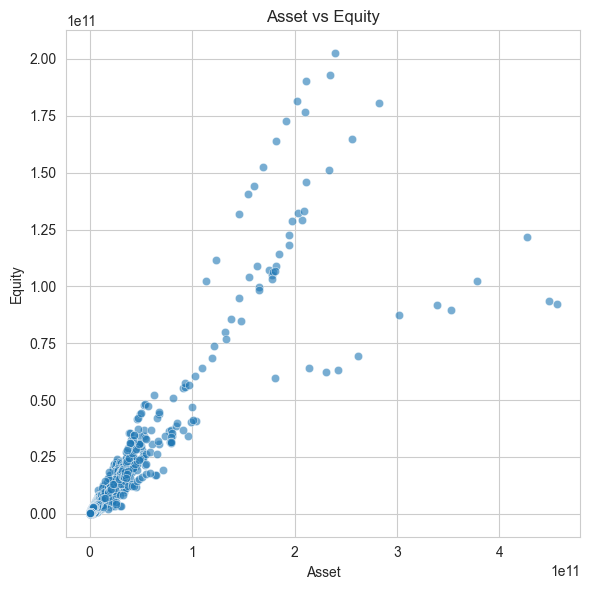

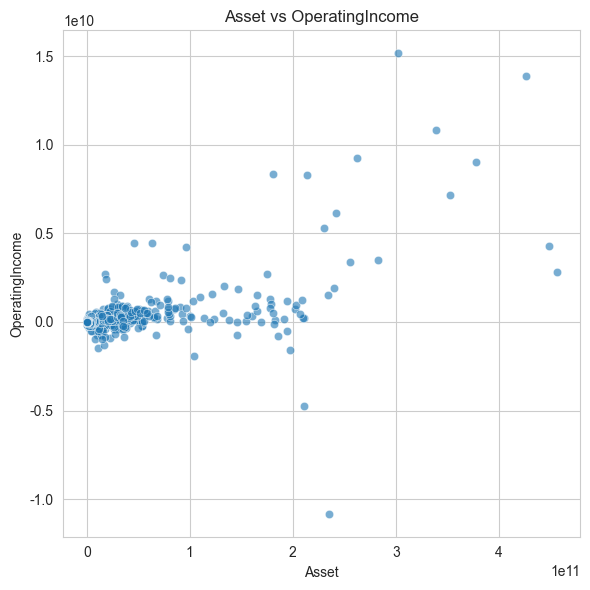

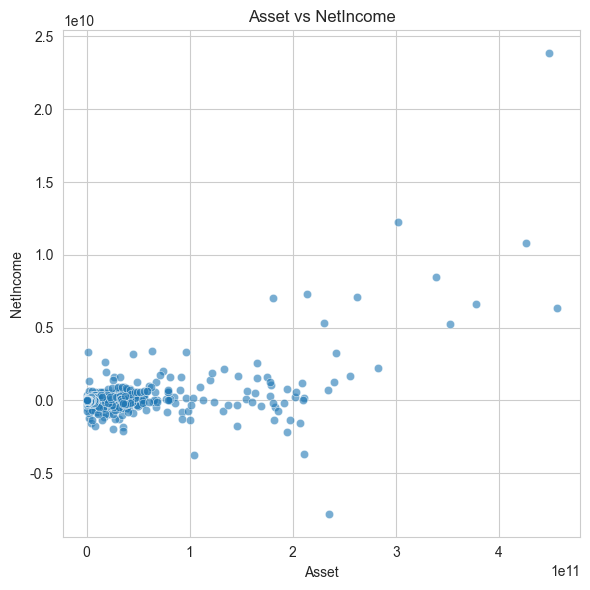

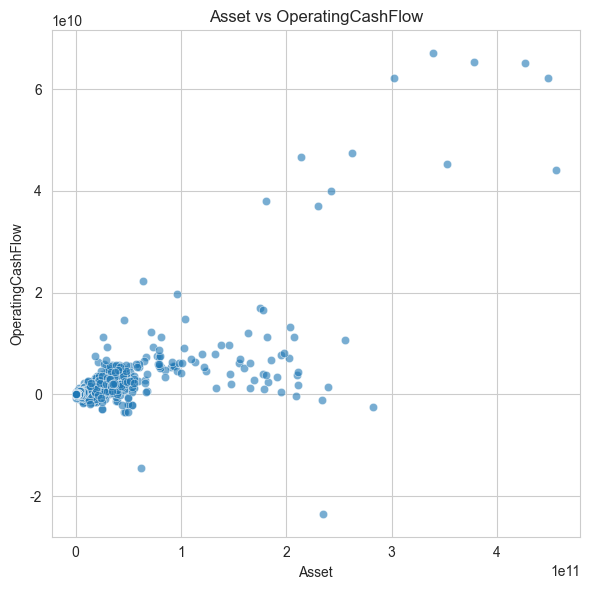

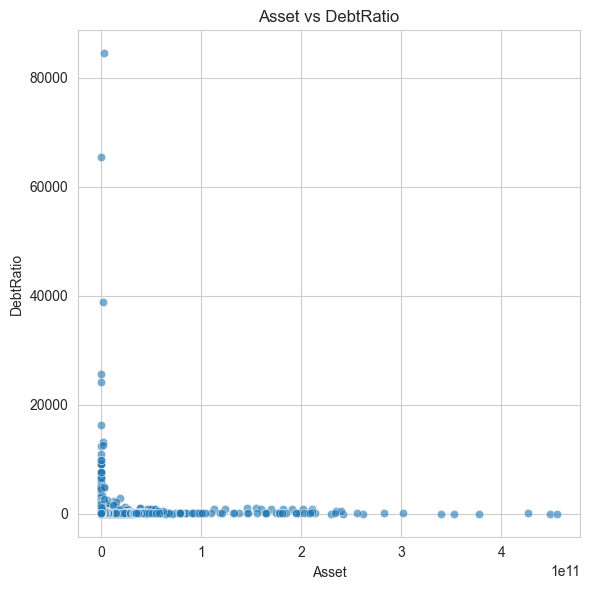

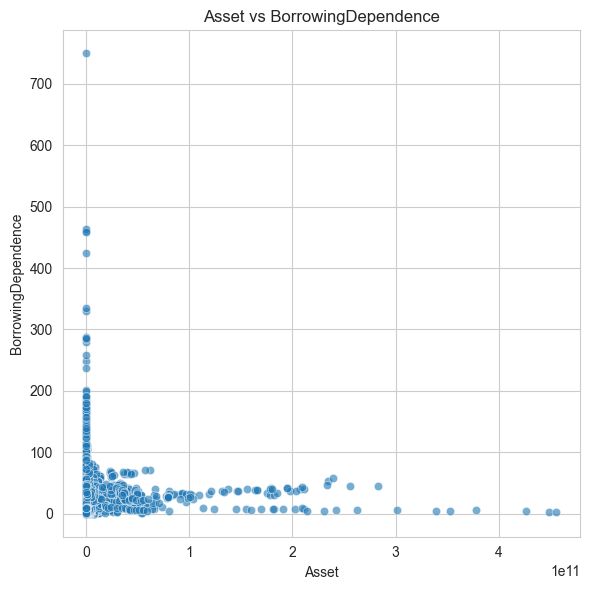

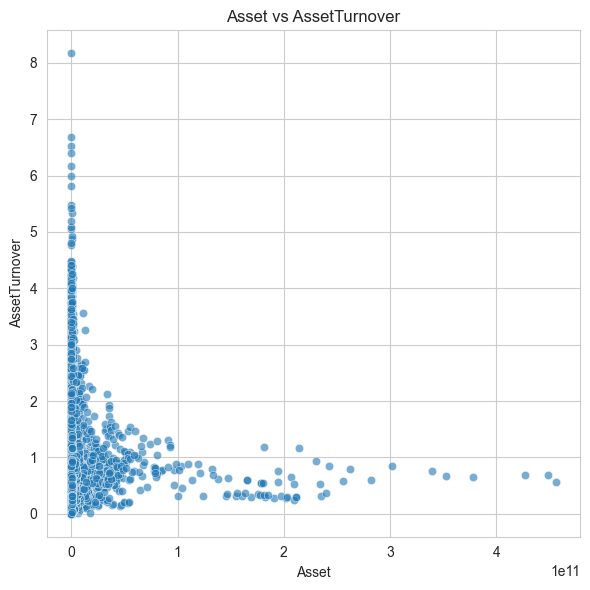

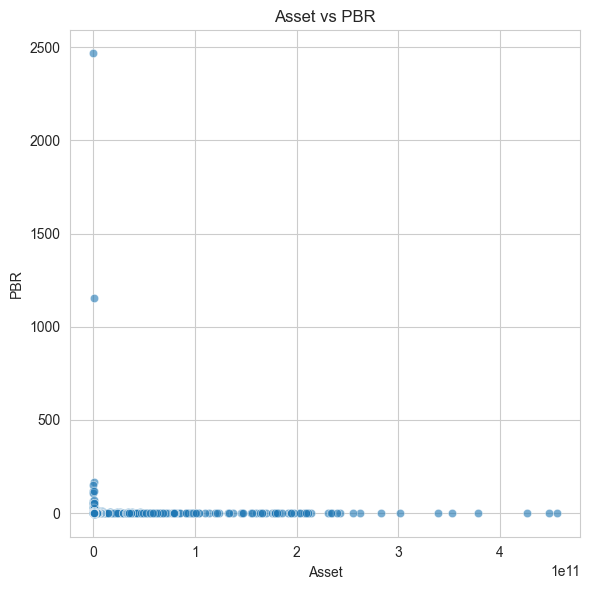

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# ─────────────────────────────────────────────
# QQ-Plot: 각 변수별로 화면에 표시
# ─────────────────────────────────────────────
for col in df.columns:
    sm.qqplot(df[col].dropna(), line='45', fit=True)
    plt.title(f"QQ Plot of {col}")
    plt.xlabel("Theoretical Quantiles")
    plt.ylabel("Sample Quantiles")
    plt.tight_layout()
    plt.show()
    plt.close()

# ─────────────────────────────────────────────
# Scatter: 'Asset' 기준으로 나머지 변수들과 화면에 표시
# ─────────────────────────────────────────────
for col in df.columns:
    if col == 'Asset':
        continue
    plt.figure(figsize=(6, 6))
    sns.scatterplot(x=df['Asset'], y=df[col], alpha=0.6)
    plt.title(f"Asset vs {col}")
    plt.xlabel("Asset")
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()
    plt.close()


In [134]:
industry = pd.read_excel("../data/raw/산업분류.xlsx")

In [66]:
industry["통계청 한국표준산업분류 11차(대분류)"].value_counts()

통계청 한국표준산업분류 11차(대분류)
제조업                         18764
정보통신업                        3552
도매 및 소매업                     2108
전문, 과학 및 기술 서비스업             2100
금융 및 보험업                     1482
건설업                           756
운수 및 창고업                      341
사업시설 관리, 사업 지원 및 임대 서비스업      248
전기, 가스, 증기 및 공기조절 공급업         164
교육 서비스업                       133
예술, 스포츠 및 여가관련 서비스업           129
부동산업                           67
숙박 및 음식점업                      58
농업, 임업 및 어업                    49
수도, 하수 및 폐기물 처리, 원료 재생업        36
협회 및 단체, 수리 및 기타 개인 서비스업       28
보건업 및 사회복지 서비스업                12
광업                              3
Name: count, dtype: int64

In [72]:
industry = industry[industry['통계청 한국표준산업분류 11차(대분류)'] != "금융 및 보험업"]
industry = industry[industry['통계청 한국표준산업분류 11차(대분류)'] != "부동산업"]
industry = industry[industry['통계청 한국표준산업분류 11차(대분류)'] != "전기, 가스, 증기 및 공기조절 공급업 (공공 유틸리티)"]
industry

,회사명,거래소코드,회계년도,통계청 한국표준산업분류 11차(대분류),통계청 한국표준산업분류 코드 11차(대분류),상장협 산업분류(대분류),상장협 산업분류 코드(대분류)
12,(주)CMG제약,58820,2012/12,제조업,21,제조업,30000
13,(주)CMG제약,58820,2013/12,제조업,21,제조업,30000
14,(주)CMG제약,58820,2014/12,제조업,21,제조업,30000
15,(주)CMG제약,58820,2015/12,제조업,21,제조업,30000
16,(주)CMG제약,58820,2016/12,제조업,21,제조업,30000
...,...,...,...,...,...,...,...
30025,흥아해운(주),3280,2019/12,운수 및 창고업,50,운수 및 창고업,80000
30026,흥아해운(주),3280,2020/12,운수 및 창고업,50,운수 및 창고업,80000
30027,흥아해운(주),3280,2021/12,운수 및 창고업,50,운수 및 창고업,80000
30028,흥아해운(주),3280,2022/12,운수 및 창고업,50,운수 및 창고업,80000


In [73]:
len(c_bs)

29527

In [74]:
# industry에 존재하는 거래소코드 목록 추출
valid_codes = industry['거래소코드'].unique()

# 각 데이터프레임에서 valid_codes에 포함된 행만 남기기
c_bs     = c_bs    [c_bs    ['거래소코드'].isin(valid_codes)].reset_index(drop=True)
c_ratio  = c_ratio [c_ratio ['거래소코드'].isin(valid_codes)].reset_index(drop=True)
n_bs     = n_bs    [n_bs    ['거래소코드'].isin(valid_codes)].reset_index(drop=True)
n_ratio  = n_ratio [n_ratio ['거래소코드'].isin(valid_codes)].reset_index(drop=True)

In [77]:
c_bs.to_csv("../data/raw/연결재무제표.csv", index=False)
n_bs.to_csv("../data/raw/개별재무제표.csv", index=False)
c_ratio.to_csv("../data/raw/연결재무비율.csv", index=False)
n_ratio.to_csv("../data/raw/개별재무비율.csv", index=False)